In [1]:
from datetime import datetime, timedelta, timezone
import pandas as pd
from robo_trader import Trader
from robo_trader.feeds import YFinanceFeed
import json
import matplotlib.pyplot as plt

In [ ]:
from robo_trader.strategy import Strategy
from robo_trader.portfolio import Portfolio
from dataclasses import dataclass
import pandas as pd
import pandas_ta as pta
import ta

@dataclass
class WtCciStAdxSettings:
    wavetrend_overbought_threshold: float = 60
    wavetrend_oversold_threshold: float = -60
    cci_overbought_threshold: float = 100
    cci_oversold_threshold: float = -100
    adx_threshold: float = 25
    supertrend_length: int = 9
    supertrend_multiplier: float = 3.0
    cci_window: int = 12
    adx_window: int = 12
    position_size:float = 0.25
    trailing_stop:float = 0.01

class WtCciStAdxStrategy(Strategy):
    def __init__(self, settings: WtCciStAdxSettings):
        super().__init__()
        self.settings = settings

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        # Make a copy of prices
        data = prices.copy()

        # Calculate WaveTrend
        data['wavetrend'] = self._calculate_wavetrend(data)
        data['wavetrend_overbought'] = data['wavetrend'] > self.settings.wavetrend_overbought_threshold
        data['wavetrend_oversold'] = data['wavetrend'] < self.settings.wavetrend_oversold_threshold

        # Calculate SuperTrend
        supertrend = pta.supertrend(data['high'], data['low'], data['close'], 
                                    length=self.settings.supertrend_length, 
                                    multiplier=self.settings.supertrend_multiplier)
        data['supertrend'] = supertrend[f'SUPERT_{self.settings.supertrend_length}_{self.settings.supertrend_multiplier}']
        data['supertrend_uptrend_approx'] = data['close'] - data['supertrend'] > 0

        # Calculate CCI
        data['cci'] = ta.trend.cci(data['high'], data['low'], data['close'], 
                                   window=self.settings.cci_window)

        # Calculate ADX
        data['adx'] = ta.trend.adx(data['high'], data['low'], data['close'], 
                                   window=self.settings.adx_window)

        # Generate long entry signal
        data['long_entry'] = ((data['wavetrend_oversold']) | 
                              (data['cci'] < self.settings.cci_oversold_threshold)) & \
                             (data['supertrend_uptrend_approx']) & \
                             (data['adx'] > self.settings.adx_threshold)

        # Get the last price point
        last_price_point = data.iloc[-1]

        # Check for long entry signal
        if last_price_point['long_entry']:
            portfolio.open_long(symbol, self.settings.position_size, self.settings.trailing_stop)

    def _calculate_wavetrend(self, data, n1=10, n2=21):
        ap = (data['high'] + data['low'] + data['close']) / 3
        esa = ap.ewm(span=n1, adjust=False).mean()
        d = (ap - esa).abs().ewm(span=n1, adjust=False).mean()
        ci = (ap - esa) / (0.015 * d)
        tci = ci.ewm(span=n2, adjust=False).mean()
        return tci

In [2]:
# SYMBOL = "BTC-GBP"
# train_since = datetime(2016, 7, 1, tzinfo=timezone.utc)
# start_date = datetime(2018, 7, 1, tzinfo=timezone.utc)
# end_date = datetime(2019, 7, 1, tzinfo=timezone.utc)
# interval = Interval.ONE_DAY
# period = 28

SYMBOL = "BTC-GBP"
train_since = datetime(2023, 12, 31, tzinfo=timezone.utc)
start_date = datetime(2024, 1, 1, tzinfo=timezone.utc)
end_date = datetime(2024, 6, 1, tzinfo=timezone.utc)
period = 24

feed = YFinanceFeed(interval = '1h')

In [3]:
default_settings = WtCciStAdxSettings(
    wavetrend_overbought_threshold=60,
    wavetrend_oversold_threshold=-60,
    cci_overbought_threshold=100,
    cci_oversold_threshold=-100,
    adx_threshold=25,
    supertrend_length=9,
    supertrend_multiplier=3.0,
    cci_window=12,
    adx_window=12,
    position_size=0.25,
    trailing_stop=0.015
)

# Write settings to disk
settings_file_path = "WtCciStAdx_optimal_settings.json"
with open(settings_file_path, "w") as settings_file:
    settings_dict = default_settings.__dict__
    json.dump(settings_dict, settings_file, indent=4)
    
print(f"Optimal settings have been written to {settings_file_path}")

Optimal settings have been written to WtCciStAdx_optimal_settings.json


In [4]:
with open(settings_file_path, "r") as settings_file:
    optimal_settings_data = json.load(settings_file)
    optimal_settings = WtCciStAdxSettings(**optimal_settings_data)

strategy = WtCciStAdxStrategy(default_settings)

# Create a Trader instance with the strategy
trader = Trader(SYMBOL, 1000, feed, strategy)

# Run the backtest
results = trader.backtest(start_date, end_date, period, train_since, transaction_cost=0.004, trailing_stop_penalty_relief=0.9)


Request to open long position on BTC-GBP
    Opening long position for BTC-GBP with for 25.0% of the cash (£250.0) and 1.5% trail
    Creating MARKET BUY order for BTC-GBP at 35743.08203125 with quantity 0.006966383027135168, trail 0.015, limit None, stop None
    Executing MARKET BUY order for BTC-GBP at 35743.08203125 with quantity 0.006966383027135168, total cost £249.996 and transaction cost £0.996
        Bought 0.006966383027135168 BTC-GBP at 35743.08203125 on 02/01/2024 19:00
    Creating TRAILING_STOP SELL order for BTC-GBP at 35743.08203125 with quantity 0.006966383027135168, trail 0.015, limit None, stop 35206.93580078125
Request to open long position on BTC-GBP
    Already long on BTC-GBP
Request to open long position on BTC-GBP
    Already long on BTC-GBP
    Updated trailing stop to 35208.6018359375
    Updated trailing stop to 35343.5468359375
    Updated trailing stop to 35374.5435546875
    Executing TRAILING_STOP SELL order for BTC-GBP at 35303.19388671875 with quantit

In [5]:
# Set display options
pd.set_option('display.max_rows', None)  # Adjust None to your specific needs
pd.set_option('display.max_columns', None)  # Adjust None as needed
pd.set_option('display.width', 1000)  # Adjust the width to fit your notebook

print('win rate: ', results['win_rate'])

display(results['returns'])

# Display the results
# Filter the history DataFrame to show only rows with True in open_long or close_long columns
filtered_history = results['history'][(results['history']['open_long'] == True) | (results['history']['close_long'] == True)]

# Display the filtered results
display(filtered_history)

display(results['orders'])


win rate:  0.2692307692307692


,start_date,end_date,price_start,price_end,valuation_start,valuation_end,asset_return,portfolio_return
0,2024-01-01 00:00:00+00:00,2024-01-02 00:00:00+00:00,33201.246094,35381.070312,1000.000000,1000.000000,0.065655,0.000000
1,2024-01-02 00:00:00+00:00,2024-01-03 00:00:00+00:00,35381.070312,35744.773438,1000.000000,999.015783,0.010280,-0.000984
2,2024-01-03 00:00:00+00:00,2024-01-04 00:00:00+00:00,35744.773438,33855.203125,999.015783,994.955828,-0.052863,-0.004064
3,2024-01-04 00:00:00+00:00,2024-01-05 00:00:00+00:00,33855.203125,34872.585938,994.955828,994.955828,0.030051,0.000000
4,2024-01-05 00:00:00+00:00,2024-01-06 00:00:00+00:00,34872.585938,34663.414062,994.955828,994.080513,-0.005998,-0.000880
5,2024-01-06 00:00:00+00:00,2024-01-07 00:00:00+00:00,34663.414062,34711.617188,994.080513,994.080513,0.001391,0.000000
6,2024-01-07 00:00:00+00:00,2024-01-08 00:00:00+00:00,34711.617188,34360.316406,994.080513,994.080513,-0.010121,0.000000
7,2024-01-08 00:00:00+00:00,2024-01-09 00:00:00+00:00,34360.316406,36644.847656,994.080513,994.080513,0.066487,0.000000
8,2024-01-09 00:00:00+00:00,2024-01-10 00:00:00+00:00,36644.847656,36068.718750,994.080513,991.948168,-0.015722,-0.002145
9,2024-01-10 00:00:00+00:00,2024-01-11 00:00:00+00:00,36068.718750,36613.890625,991.948168,991.948168,0.015115,0.000000


,open,high,low,close,volume,Dividends,Stock Splits,open_long,close_long
date,,,,,,,,,
2024-01-02 19:00:00+00:00,35763.406250,35840.304688,35531.390625,35743.082031,160575488,0.0,0.0,True,False
2024-01-03 11:00:00+00:00,35773.527344,35783.441406,34566.507812,34661.046875,1719267328,0.0,0.0,False,True
2024-01-05 01:00:00+00:00,34881.515625,34910.359375,33709.738281,34218.644531,1519818752,0.0,0.0,True,False
2024-01-05 14:00:00+00:00,34781.093750,34806.417969,34177.773438,34290.750000,276340736,0.0,0.0,False,True
2024-01-09 12:00:00+00:00,36698.265625,36889.503906,35981.191406,36329.496094,0,0.0,0.0,True,False
2024-01-09 21:00:00+00:00,36746.433594,37695.265625,35606.324219,35743.945312,5669066752,0.0,0.0,False,True
2024-01-27 06:00:00+00:00,32859.144531,32897.253906,32819.582031,32819.582031,0,0.0,0.0,True,False
2024-01-28 18:00:00+00:00,33177.816406,33177.816406,33024.015625,33070.339844,274907136,0.0,0.0,False,True
2024-02-02 09:00:00+00:00,33739.500000,33739.500000,33664.140625,33679.679688,0,0.0,0.0,True,False


{'91fc2e87-a713-4b34-b023-27500a2ddc1d': Order(symbol='BTC-GBP', order_type='MARKET', order_side='BUY', quantity=0.006966383027135168, trail=0.015, limit=None, stop=None, id='91fc2e87-a713-4b34-b023-27500a2ddc1d', timestamp=Timestamp('2024-01-02 19:00:00+0000', tz='UTC'), status='FILLED', trades=[Trade(id='2411aaef-1893-4560-9f07-a33c41bf3bef', order_id='91fc2e87-a713-4b34-b023-27500a2ddc1d', symbol='BTC-GBP', order_type='MARKET', order_side='BUY', price=35743.08203125, quantity=0.006966383027135168, timestamp=Timestamp('2024-01-02 19:00:00+0000', tz='UTC'), transaction_costs=0.996)]),
 '4aa5c225-9176-40a0-8cf7-575e04a9f26d': Order(symbol='BTC-GBP', order_type='TRAILING_STOP', order_side='SELL', quantity=0.006966383027135168, trail=0.015, limit=None, stop=35374.5435546875, id='4aa5c225-9176-40a0-8cf7-575e04a9f26d', timestamp=Timestamp('2024-01-02 19:00:00+0000', tz='UTC'), status='FILLED', trades=[Trade(id='e4718cba-0160-41f7-9642-4d232b8ebb48', order_id='4aa5c225-9176-40a0-8cf7-575e04

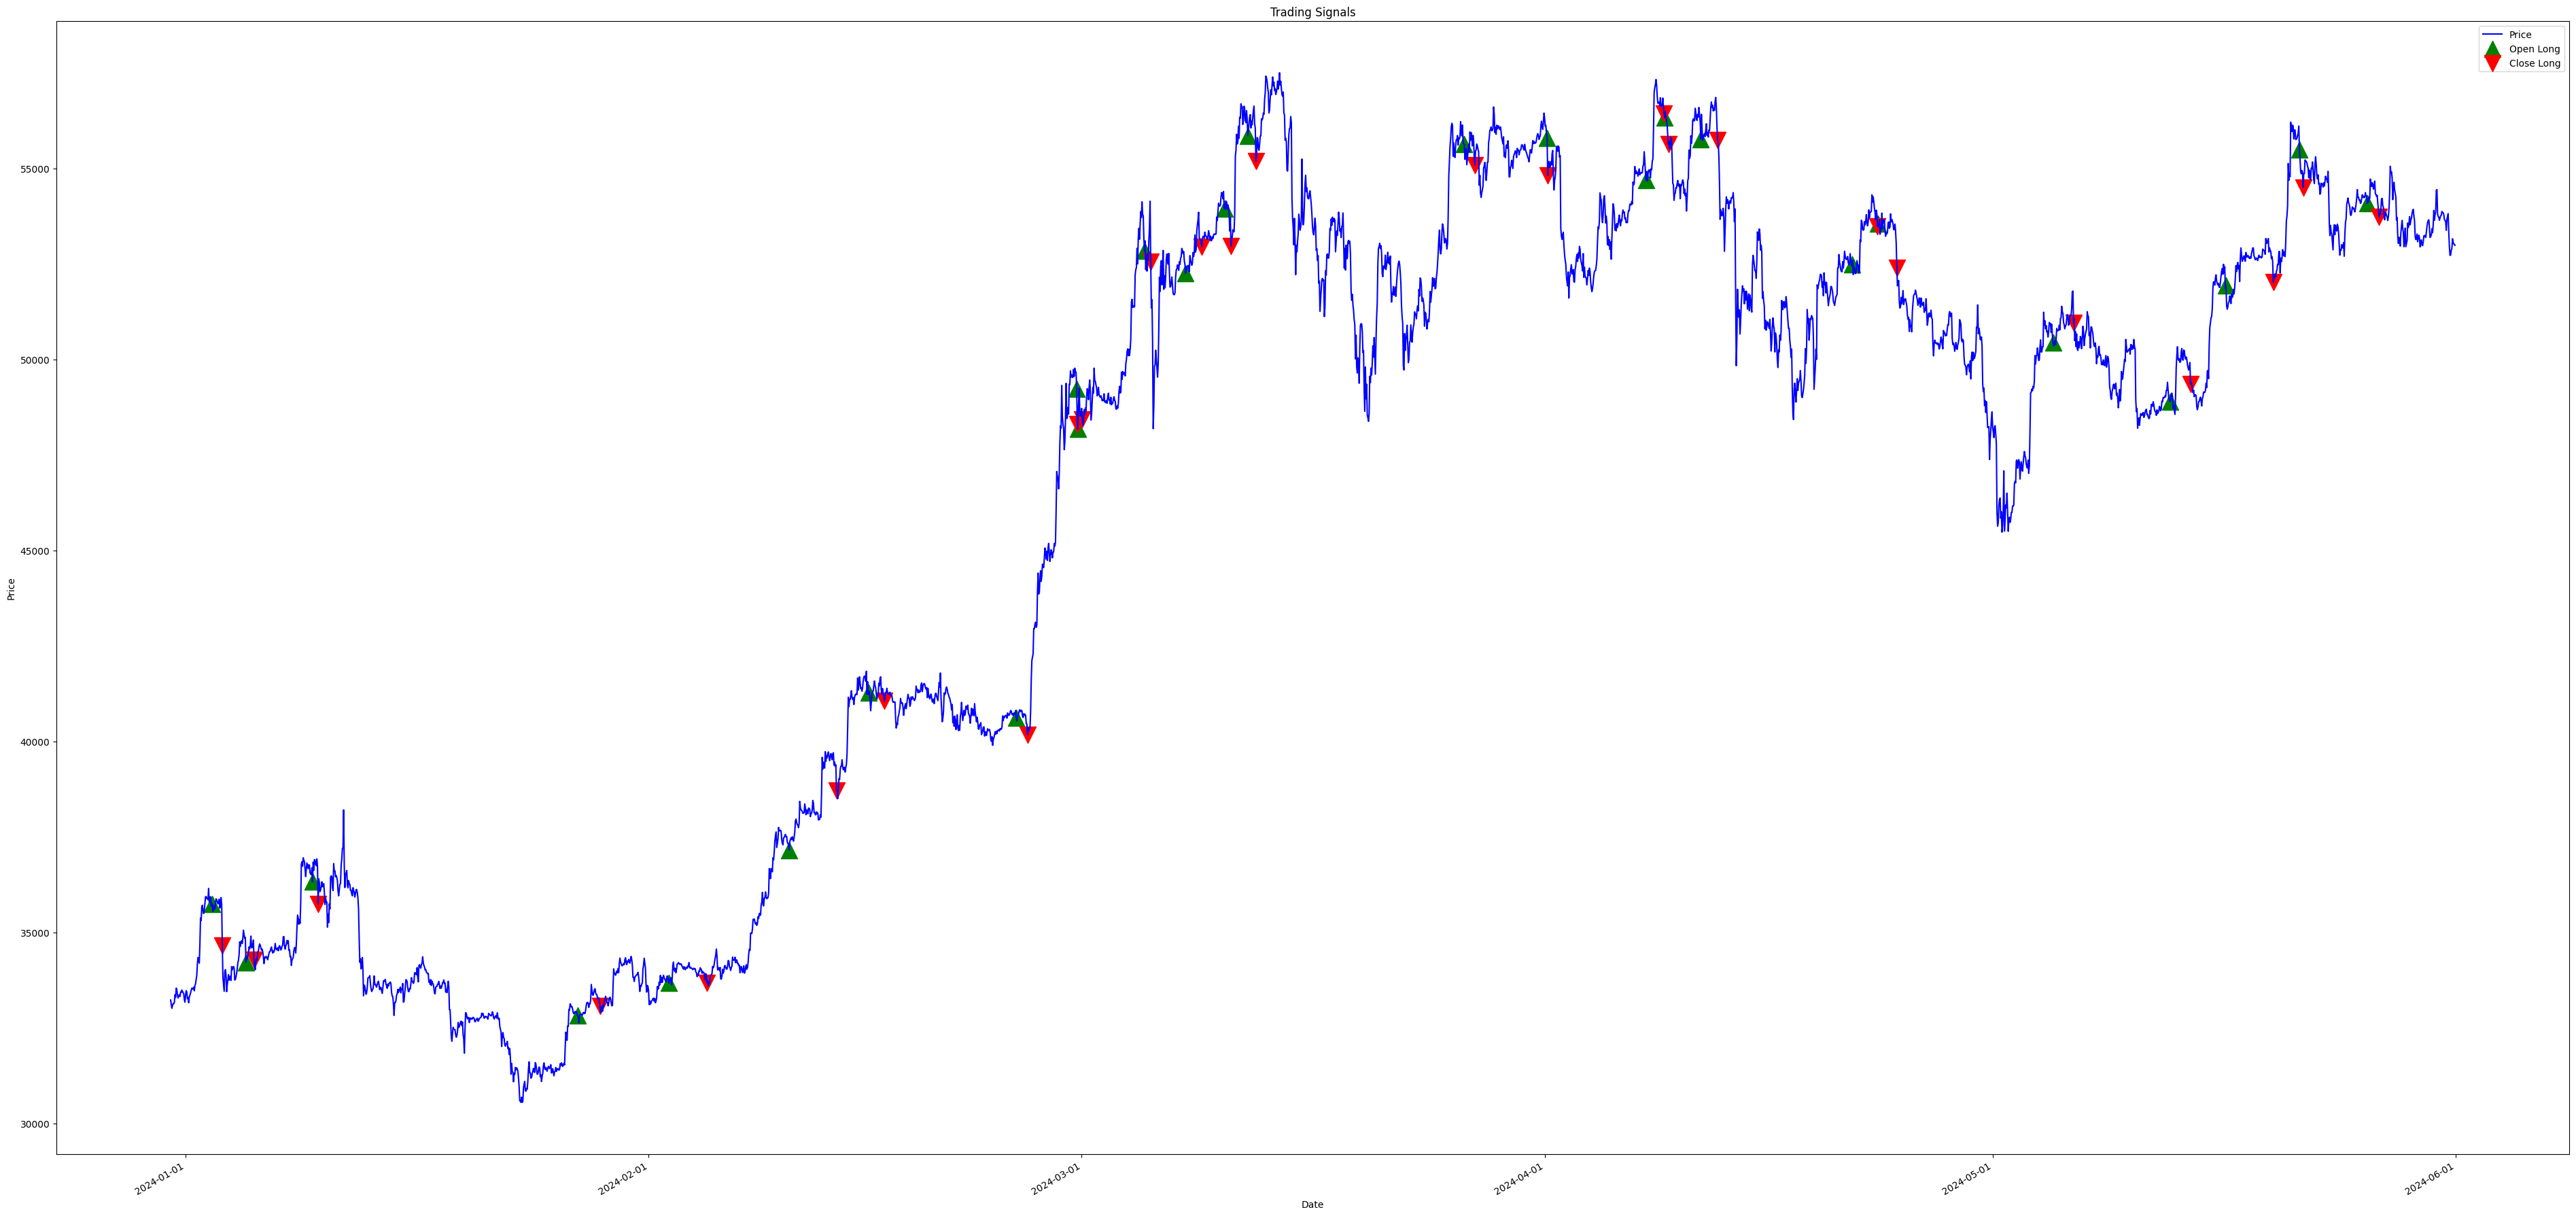

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert the index to datetime if it's not already
results['history'].index = pd.to_datetime(results['history'].index)

# Create the plot
fig, ax = plt.subplots(figsize=(38, 18))

# Plot the price
ax.plot(results['history'].index, results['history']['close'], color='blue', label='Price')

# Plot green arrows for open_long
open_long = results['history'][results['history']['open_long']]
ax.scatter(open_long.index, open_long['close'], color='green', marker='^', s=300, label='Open Long')

# Plot red arrows for close_long
close_long = results['history'][results['history']['close_long']]
ax.scatter(close_long.index, close_long['close'], color='red', marker='v', s=300, label='Close Long')

# Customize the plot
ax.set_title('Trading Signals')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

# Format x-axis to show dates nicely
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Show the plot
plt.tight_layout()
plt.show()
